In [1]:
import nengo
import numpy as np
import math
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
from nengo.processes import Piecewise
from nengo.dists import Uniform
import scipy.special

class AreaIntercepts(nengo.dists.Distribution):
    """ Generate an optimally distributed set of intercepts in
    high-dimensional space.
    """
    dimensions = nengo.params.NumberParam('dimensions')
    base = nengo.dists.DistributionParam('base')

    def __init__(self, dimensions, base=nengo.dists.Uniform(-1, 1)):
        super(AreaIntercepts, self).__init__()
        self.dimensions = dimensions
        self.base = base

    def __repr(self):
        return ("AreaIntercepts(dimensions=%r, base=%r)" %
                (self.dimensions, self.base))

    def transform(self, x):
        sign = 1
        if x > 0:
            x = -x
            sign = -1
        return sign * np.sqrt(1 - scipy.special.betaincinv(
            (self.dimensions + 1) / 2.0, 0.5, x + 1))

    def sample(self, n, d=None, rng=np.random):
        s = self.base.sample(n=n, d=d, rng=rng)
        for i in range(len(s)):
            s[i] = self.transform(s[i])
        return s
    
def inverse_kinematics_numeric(L = [1, 1, 1], neurons_per_rad = 200, adaptation_rate=0.005):

    model = nengo.Network(seed=10)
    model.config[nengo.Ensemble].neuron_type = nengo.Direct()
    with model:
        
        NORMALIZE_FACTOR = 1000
        END_EFFECTOR_COORIDINATES_TOLERANCE = 0.001 / NORMALIZE_FACTOR 
        CONSIDER_THETA1_NODE = 1
        CONSIDER_THETA2_NODE = 1
        
        l1 = float(L[0]) / NORMALIZE_FACTOR
        l2 = float(L[1]) / NORMALIZE_FACTOR
        l3 = float(L[2]) / NORMALIZE_FACTOR
        
        #l1 = L[0]
        #l2 = L[1]
        #l3 = L[2]
        
        def scale_up(x):
            return x * NORMALIZE_FACTOR
            
        def scale_down(x):
            return x / NORMALIZE_FACTOR
    
        def scale_up_angle(x):
            return x * np.pi + np.pi
            
        def scale_down_angle(x):
            return (x - np.pi) / (np.pi)

        model.stim_x = nengo.Node(output=None, size_in=1)
        model.stim_y = nengo.Node(output=None, size_in=1)
        
        
        
        model.array = nengo.Ensemble(n_neurons=int(6*neurons_per_rad), 
                                    dimensions=2, radius=np.sqrt(2*(l1+l2)**2),
                                        intercepts=AreaIntercepts(
                                        dimensions=2,
                                        base=nengo.dists.Uniform(-.1, .1))) 
       
        model.array_probe = []
        for i, ens in enumerate([model.array]):
            model.array_probe.append(nengo.Probe(ens, synapse=0.01))
            nengo.Connection(model.stim_x, ens[0])
            nengo.Connection(model.stim_y, ens[1])
        
       
        model.stim_theta1 = nengo.Node(output=None, size_in=1)
        model.stim_theta2 = nengo.Node(output=None, size_in=1)
        
          
        #calculate Y - according to FK
        model.theta12=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=2, radius=np.sqrt(2))
        
        
  #      nengo.Connection(model.stim_theta1, model.theta12[0],transform=CONSIDER_THETA1_NODE)
  #      nengo.Connection(model.stim_theta2, model.theta12[1],transform=CONSIDER_THETA2_NODE)
        
        
        model.sin_theta1=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1)
        model.sin_theta12=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1)
        
        
        def calculate_sintheta1(theta):
            if CONSIDER_THETA1_NODE: t = scale_up_angle(theta[0])
            else: t = 0
            return np.sin(t)
        
        def calculate_sintheta12(theta):
            if CONSIDER_THETA1_NODE: t1 = scale_up_angle(theta[0])
            else: t1 = 0
            if CONSIDER_THETA1_NODE: t2 = scale_up_angle(theta[1])
            else: t2 = 0
            t = t1+t2
            return np.sin(t)
        
        nengo.Connection(model.theta12, model.sin_theta1,function=calculate_sintheta1)
        nengo.Connection(model.theta12, model.sin_theta12,function=calculate_sintheta12)  
        
        
        model.l1_sin_theta1=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1,
                                        intercepts=AreaIntercepts(
                                        dimensions=1,
                                        base=nengo.dists.Uniform(-.01, .01)))
        model.l2_sin_theta12=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l2,
                                        intercepts=AreaIntercepts(
                                        dimensions=1,
                                        base=nengo.dists.Uniform(-.01, .01)))
        
      
        
        def calculate_l1_theta(theta): 
            return l1*theta
        
        def calculate_l2_theta(theta): 
            return l2*theta
        
        nengo.Connection(model.sin_theta1,  model.l1_sin_theta1,function=calculate_l1_theta)
        nengo.Connection(model.sin_theta12, model.l2_sin_theta12,function=calculate_l2_theta)
     
        model.Y = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2,
                                        intercepts=AreaIntercepts(
                                        dimensions=1,
                                        base=nengo.dists.Uniform(-.01, .01)))
       
        nengo.Connection(model.l1_sin_theta1, model.Y)
        nengo.Connection(model.l2_sin_theta12, model.Y)
        
       
        
        
        
        # calculate X - according to FK
        model.cos_theta1=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1)
        model.cos_theta12=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1)
        
       
        def calculate_costheta1(theta): 
            t = scale_up_angle(theta[0])
            return np.cos(t)
        
        def calculate_costheta12(theta): 
            t1 = scale_up_angle(theta[0])
            t2 = scale_up_angle(theta[1])
            t = t1+t2
            return np.cos(t)
        
        nengo.Connection(model.theta12, model.cos_theta1,function=calculate_costheta1)
        nengo.Connection(model.theta12, model.cos_theta12,function=calculate_costheta12)   
        
       
        model.l1_cos_theta1=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1,
                                        intercepts=AreaIntercepts(
                                        dimensions=1,
                                        base=nengo.dists.Uniform(-.01, .01)))
        model.l2_cos_theta12=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l2,
                                        intercepts=AreaIntercepts(
                                        dimensions=1,
                                        base=nengo.dists.Uniform(-.01, .01)))
        
        
        nengo.Connection(model.cos_theta1, model.l1_cos_theta1,function=calculate_l1_theta)
        nengo.Connection(model.cos_theta12, model.l2_cos_theta12,function=calculate_l2_theta)
        
       
        model.X = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2,
                                        intercepts=AreaIntercepts(
                                        dimensions=1,
                                        base=nengo.dists.Uniform(-.01, .01)))
     
        nengo.Connection(model.l1_cos_theta1, model.X)
        nengo.Connection(model.l2_cos_theta12, model.X)
        
       
    
       
        
        #calculate Deltas
        model.xDelta=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2)
        model.yDelta=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2)
        
        
        nengo.Connection(model.array[0], model.xDelta)
        nengo.Connection(model.array[1], model.yDelta)
        nengo.Connection(model.X, model.xDelta, transform=-1)
        nengo.Connection(model.Y, model.yDelta, transform=-1)
        
       
        
        #calculate if to keep calculating
        model.IsPoseEqualtoEndEffectorX = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, 
                                                         radius=1)
        model.IsPoseEqualtoEndEffectorY = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, 
                                                         radius=1)
        
        
        def check_difference(Delta):
            if Delta < 0:
                if Delta > (END_EFFECTOR_COORIDINATES_TOLERANCE * -1): return 1
            else:
                if Delta < END_EFFECTOR_COORIDINATES_TOLERANCE: return 1
            return 0
        
        nengo.Connection(model.xDelta,model.IsPoseEqualtoEndEffectorX, function=check_difference)
        nengo.Connection(model.yDelta,model.IsPoseEqualtoEndEffectorY, function=check_difference)
        
       
        model.IsPoseEqualtoEndEffector_array = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=2,radius=1)
       
        nengo.Connection(model.IsPoseEqualtoEndEffectorX,model.IsPoseEqualtoEndEffector_array[0])
        nengo.Connection(model.IsPoseEqualtoEndEffectorY,model.IsPoseEqualtoEndEffector_array[1])
        
       
        model.IsPoseEqualtoEndEffector = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, 
                                                        radius=1)
        
        def multiply2(array):
            return array[0]*array[1]
        
        nengo.Connection(model.IsPoseEqualtoEndEffector_array,model.IsPoseEqualtoEndEffector, function=multiply2)
        
        
        
         # calculate Jacobian
            # J = np.array([[a11,a12],
            #           [a21,a22],       
            #           ])
        
        model.a11 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2)
        model.a12 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l2)
        model.a21 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2)
        model.a22 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l2)
        
        
        nengo.Connection(model.Y,model.a11,transform=-1)
        nengo.Connection(model.l2_sin_theta12,model.a12,transform=-1)
        nengo.Connection(model.X,model.a21)
        nengo.Connection(model.l2_cos_theta12,model.a22)
        
       
        model.J_ens = nengo.Ensemble(n_neurons=15*neurons_per_rad, dimensions=7, 
                               radius=np.sqrt(4*(l1+l2)**2+2*(l2)**2+1),
                                        intercepts=AreaIntercepts(
                                        dimensions=7,
                                        base=nengo.dists.Uniform(-.1, .1)))
       
        nengo.Connection(model.a11,model.J_ens[0])
        nengo.Connection(model.a12,model.J_ens[1]) 
        nengo.Connection(model.a21,model.J_ens[2])
        nengo.Connection(model.a22,model.J_ens[3])
        nengo.Connection(model.xDelta,model.J_ens[4])
        nengo.Connection(model.yDelta,model.J_ens[5])
        nengo.Connection(model.IsPoseEqualtoEndEffector,model.J_ens[6])
        
        
        model.pre_theta1 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=2, radius=np.sqrt(2))
        model.pre_theta2 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=2, radius=np.sqrt(2))
        
        nengo.Connection(model.theta12[0], model.pre_theta1[0])
        nengo.Connection(model.theta12[1], model.pre_theta2[0])
        
        def calculate_J_theta1(J):
            global CONSIDER_THETA1_NODE
            newAngles=[0,0]
            if(J[6] > 0):
                j = np.array([[J[0],J[1]], [J[2],J[3]]])
        
                inverseJ = np.linalg.pinv(j) # Jacobian pseudo inverse
                deltaMatrix = np.array([J[4], J[5]]).T # x, y, z, phie delta change vector
                newAngles = inverseJ.dot(deltaMatrix) # J^-1 dot product with x, y, z, phie delta change vector
            final = newAngles[0]*adaptation_rate
            CONSIDER_THETA1_NODE = 0
            return scale_down_angle(final)
        
        def calculate_J_theta2(J):
            global CONSIDER_THETA2_NODE
            newAngles=[0,0]
            if(J[6] > 0):
                j = np.array([[J[0],J[1]], [J[2],J[3]]])
        
                inverseJ = np.linalg.pinv(j) # Jacobian pseudo inverse
                deltaMatrix = np.array([J[4], J[5]]).T # x, y, z, phie delta change vector
                newAngles = inverseJ.dot(deltaMatrix) # J^-1 dot product with x, y, z, phie delta change vector
            final = newAngles[1]*adaptation_rate
            CONSIDER_THETA2_NODE = 0
            return scale_down_angle(final)
        
        
        #adding the new angles values according to J
        nengo.Connection(model.J_ens,model.pre_theta1[1],function=calculate_J_theta1)
        nengo.Connection(model.J_ens,model.pre_theta2[1],function=calculate_J_theta2)
        
                 
        def calculate_scaled_theta(pre_theta): 
            t1 = scale_up_angle(pre_theta[0])
            t2 = scale_up_angle(pre_theta[1])
            t = t1+t2
            return scale_down_angle(t)  
            
            
        nengo.Connection(model.pre_theta1, model.theta12[0], function=calculate_scaled_theta)
        nengo.Connection(model.pre_theta2, model.theta12[1], function=calculate_scaled_theta)    
            
        model.probe_pre_theta1 = nengo.Probe(model.pre_theta1[1], synapse=0.01)
        model.probe_pre_theta2 = nengo.Probe(model.pre_theta2[1], synapse=0.01)
        
        model.probe_theta1 = nengo.Probe(model.theta12[0], synapse=0.01)
        model.probe_theta2 = nengo.Probe(model.theta12[1], synapse=0.01)
        
        
        model.probe_X = nengo.Probe(model.X, synapse=0.01)
        model.probe_Y = nengo.Probe(model.Y, synapse=0.01)
        
        return model
    
    
model = nengo.Network(label='Inverse Kinematics numeric')

with model:
    NORMALIZE_FACTOR = 1000
    def scale_down(x):
            return x / NORMALIZE_FACTOR
        
    def scale_down_angle(x):
            return (x - np.pi) / (np.pi)
        
  #  stim_x = nengo.Node(Piecewise({0: scale_down(np.sqrt(0.5)+1)}))     
  #  stim_y = nengo.Node(Piecewise({0: scale_down(0.5)})  
                        
    stim_x = nengo.Node(Piecewise({0: scale_down(0)}))                
    stim_y = nengo.Node(Piecewise({0: scale_down(2)}))                    
                                                                       
    
    ik = inverse_kinematics_numeric()
    
    nengo.Connection(stim_x, ik.stim_x)
    nengo.Connection(stim_y, ik.stim_y)
    
    
    print(model.n_neurons)       

18000


In [2]:
with nengo.Simulator(model) as sim:
#    eval_points, activities = tuning_curves(ik.theta12, sim)
    sim.run(8)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

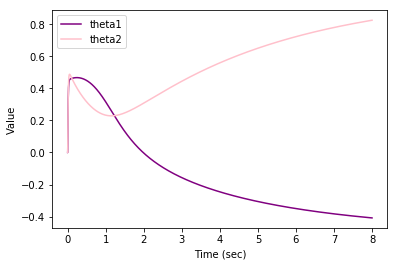

In [3]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Value");
plt.plot(sim.trange(), sim.data[ik.probe_theta1], color = 'purple',label="theta1")
plt.plot(sim.trange(), sim.data[ik.probe_theta2], color = 'pink',label="theta2")
plt.legend()
plt.savefig('loc.jpg', dpi=350)

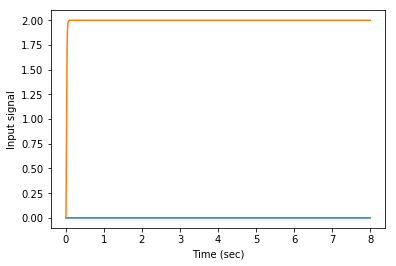

In [4]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Input signal");
plt.plot(sim.trange(), sim.data[ik.array_probe[0]]*1000)
plt.savefig('xyz.jpg', dpi=350)

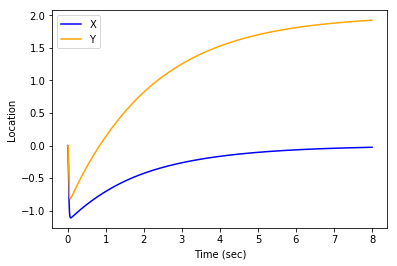

In [5]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Location");
plt.plot(sim.trange(), sim.data[ik.probe_X]*1000, label="X", color = 'blue')
plt.plot(sim.trange(), sim.data[ik.probe_Y]*1000, label="Y", color = 'orange')
plt.legend()
plt.savefig('loc.jpg', dpi=350)

In [209]:

#plt.figure()
#plt.plot(eval_points, activities, lw=1)
#plt.xlabel("Input signal")
#plt.ylabel("Firing rate (Hz)");
